# Surrogate modeling

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rcupd = {
    'figure.figsize': (5, 4),
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'font.size': 12,
}
plt.rcParams.update(rcupd)

In [3]:
jar = pd.read_csv('normal.csv')

fdVals = jar['FD'].unique()

hi_fd = jar[jar['FD'] == fdVals[-2]]
hi_fd = hi_fd.drop(['FD', 'fuel_gas_swelling'], axis=1)

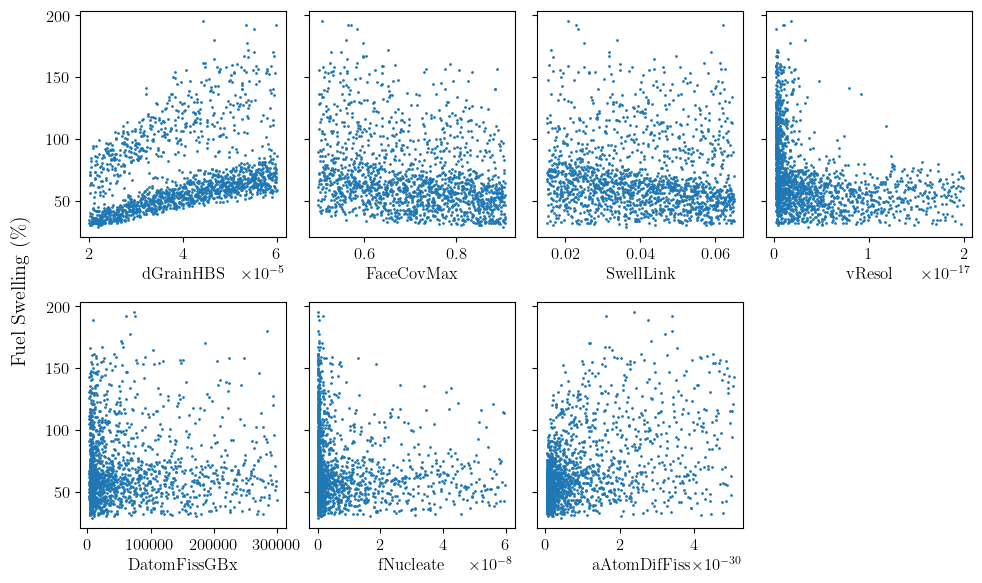

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(hi_fd.iloc[:,i], hi_fd.iloc[:,7], s=1)
    ax.set_xlabel(hi_fd.columns[i])

fig.delaxes(axes[1,3])
fig.supylabel(r'Fuel Swelling (\%)')
plt.tight_layout()
plt.show()

# Train/test split

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
feat_ind = list(range(7))
features = hi_fd.iloc[:, feat_ind]
xscaler = MinMaxScaler()
X = xscaler.fit_transform(features)
y = hi_fd['fuel_swelling']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

# Convenience functions

In [8]:
def lin_coef_cept(mod):
    print(
        ' coeffs: ',
        mod.coef_, '\n',
        'intercept: ',
        mod.intercept_
    )

In [9]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

def mod_metrics(mod, X_test, y_test):
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(
        ' R2: ', r2, '\n',
        'RMSE: ', rmse, '\n',
        'MAE: ', mae
    )

In [10]:
def pred_vs_actual(mod, X_test, y_test, tt):
    y_pred = mod.predict(X_test)

    plt.figure(figsize=(5,4))
    plt.rcParams.update({'font.size': 16})

    plt.scatter(y_test, y_pred, s=15)
    plt.plot(list(range(100)), list(range(100)),
             color='k', ls='--', label='y=x')

    plt.title(tt)
    plt.xlabel(r'Test data (swelling \%)')
    plt.ylabel(r'Surrogate pred. (swelling \%)')
    plt.legend()
    plt.show()

# Linear (OLS)

In [11]:
from sklearn import linear_model

 coeffs:  [ 3.34353345e+01 -2.85189703e+01 -7.88833874e+00  1.24721904e-14
  1.56432295e+00 -1.74202668e+01  6.46228383e-27] 
 intercept:  73.97442494901662
 R2:  0.234000371166749 
 RMSE:  26.014079477567524 
 MAE:  21.24474638502474


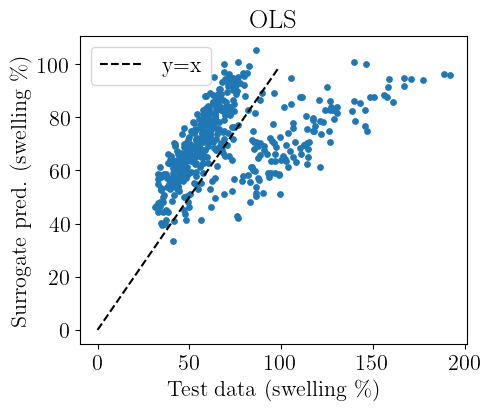

In [12]:
reg_lin = linear_model.LinearRegression().fit(X_train, y_train)

lin_coef_cept(reg_lin)
mod_metrics(reg_lin, X_test, y_test)
pred_vs_actual(reg_lin, X_test, y_test, 'OLS')

# Lasso

 coeffs:  [ 21.55241108 -15.84479523  -0.          -0.           0.
  -0.           0.        ] 
 intercept:  67.29782981193131
 R2:  0.17047491351225363 
 RMSE:  27.071289635738843 
 MAE:  21.428790554114133


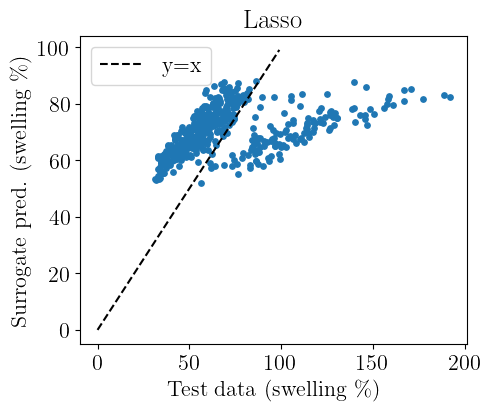

In [13]:
reg_las = linear_model.Lasso().fit(X_train, y_train)

lin_coef_cept(reg_las)
mod_metrics(reg_las, X_test, y_test)
pred_vs_actual(reg_las, X_test, y_test, 'Lasso')

# NN

In [14]:
from sklearn.neural_network import MLPRegressor

In [15]:
reg_nn = MLPRegressor(
    hidden_layer_sizes=(50, 100, 50),
    alpha=0,
    random_state=37,
    max_iter=5000,
    tol=0.1
).fit(X_train, y_train)

 R2:  0.23713101313491292 
 RMSE:  25.96086525360982 
 MAE:  21.406891823104967


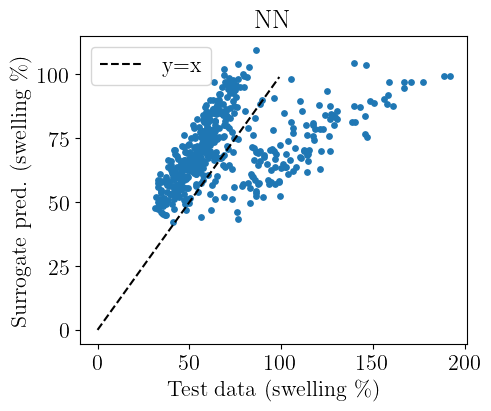

In [16]:
mod_metrics(reg_nn, X_test, y_test)
pred_vs_actual(reg_nn, X_test, y_test, 'NN')

# SVR

In [17]:
from sklearn.svm import SVR

In [18]:
reg_svr = SVR(kernel='rbf').fit(X_train, y_train)

 R2:  -0.025327813470720884 
 RMSE:  30.09716244732106 
 MAE:  16.741627152985718


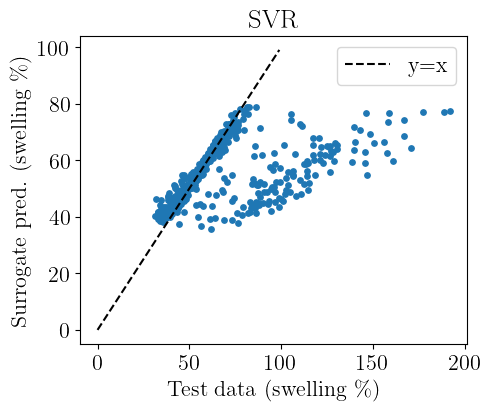

In [19]:
mod_metrics(reg_svr, X_test, y_test)
pred_vs_actual(reg_svr, X_test, y_test, 'SVR')

In [20]:
y_pred = reg_svr.predict(X_test)

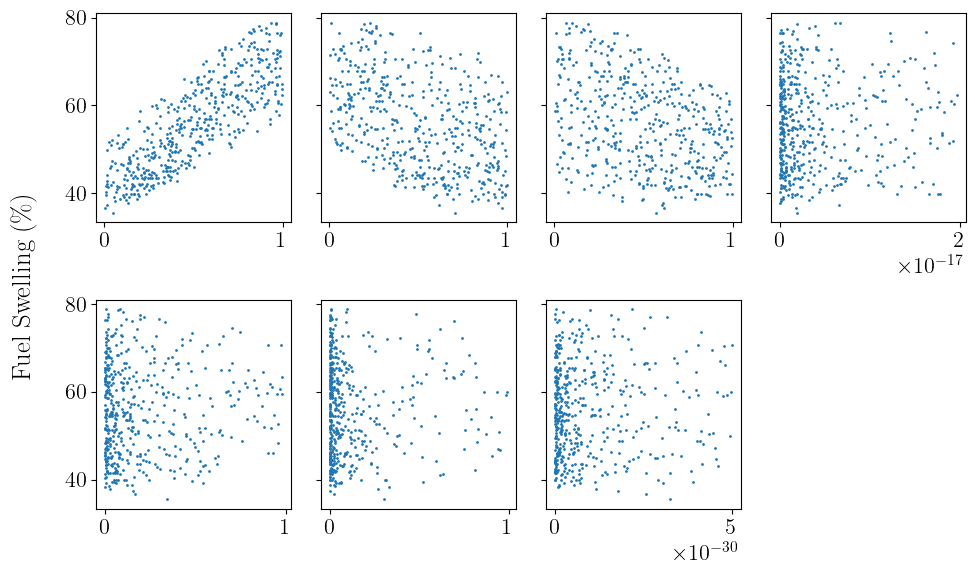

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i in range(7):
    axes[i//4,i%4].scatter(X_test[:,i], y_pred, s=1)
    #ax.set_xlabel(X_test.columns[i])

fig.delaxes(axes[1,3])
fig.supylabel(r'Fuel Swelling (\%)')
plt.tight_layout()
plt.show()